In [1]:
from sympy import Symbol, diff, lambdify, symbols, sqrt, cos
import numpy as np
from sympy import init_printing
init_printing()

In [2]:
m = Symbol('m')
k = Symbol('k')
q = Symbol('q')
p = Symbol('p')
H = p**2/(2.*m) + 0.5*k*q**2

In [3]:
qdot = lambdify((q,p,m,k), diff(H, p), 'numpy')

In [4]:
pdot = lambdify((q,p,m,k), -diff(H, q), 'numpy')

In [5]:
def diffeq(y, t, m,k):
    q,p = y
    dydt = [qdot(q,p,m,k), pdot(q,p,m,k)]
    return dydt

In [6]:
y0 = [1,0]

In [7]:
t = np.linspace(0,10, 100)

In [8]:
from scipy.integrate import odeint
m=1.
k=0.5
a = (m,k)
sol = odeint(diffeq, y0, t, args=(m,k))

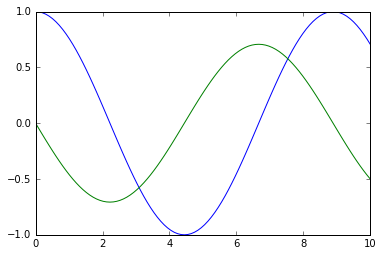

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(t, sol[:,0])
plt.plot(t, sol[:,1])

In [10]:
m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha = symbols("m, m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, P1, P2, p1, p2, alpha")

In [11]:
f27 = -0.46 - 0.802*m
f31 = 0.87 + 0.802*m

In [12]:
H = -mu1/(2.*Lambda1**2) - mu2/(2.*Lambda2**2) - m1/M1*mu2/Lambda2**2*(f27*sqrt(2.*P1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + p1) + f31*sqrt(2.*P2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + p2))

In [13]:
J1, J2, Gamma1, Gamma2, phi1, phi2 = symbols("J1, J2, Gamma1, Gamma2, phi1, phi2")

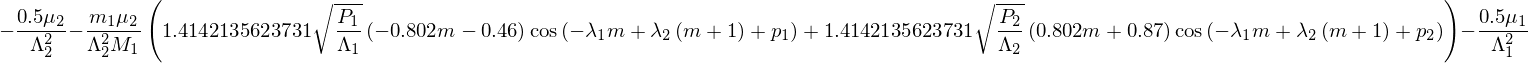

In [14]:
H

In [15]:
H2 = H
H2 = H2.subs(P1, Gamma1)
H2 = H2.subs(P2, Gamma2)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p1, phi1)
H2 = H2.subs((m+1)*lambda2 - m*lambda1 + p2, phi2)
H2 = H2.subs(Lambda1, J1 - m*(Gamma1 + Gamma2))
H2 = H2.subs(Lambda2, J2 + (m+1)*(Gamma1 + Gamma2))

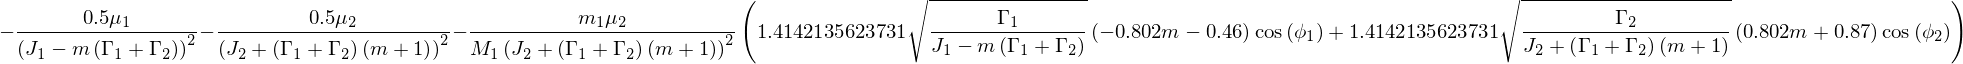

In [16]:
H2

In [17]:
var = (mu1, J1, m, mu2, J2, m1, M1, phi1, phi2, Gamma1, Gamma2)
params = (mu1, J1, m, mu2, J2, m1, M1)

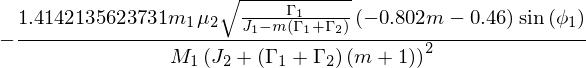

In [18]:
-diff(H2,phi1)

In [19]:
Gamma1dot = lambdify(var, -diff(H2, phi1), 'numpy')
Gamma2dot = lambdify(var, -diff(H2, phi2), 'numpy')
phi1dot = lambdify(var, diff(H2, Gamma1), 'numpy')
phi2dot = lambdify(var, diff(H2, Gamma2), 'numpy')

In [38]:
def diffeq(y, t, mu1, J1, m, mu2, J2, m1, M1):
    phi1, phi2, Gamma1, Gamma2 = y
    dydt = [phi1dot(*var), phi2dot(*var), Gamma1dot(*var), Gamma2dot(*var)]
    return dydt

In [39]:
import rebound
import numpy as np
m=2.
sim = rebound.Simulation()
sim.add(m=3.)
sim.add(m=1.e-5, e=0.001, P=2.)
sim.add(m=1.e-5, e=0.001, P=(m+1)/m*2.)
sim.move_to_com()
ps = sim.particles
ps[1].hash = 1
ps[2].hash = 2

In [40]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)

In [41]:
y0 = [0., 0., ps[1].Gamma, ps[2].Gamma]

In [42]:
Norbits = 5000
Nout = 10000
tmax = Norbits*sim.particles[2].P
times = np.linspace(0, tmax, Nout, endpoint=False)

In [43]:
from scipy.integrate import odeint
sol = odeint(diffeq, y0, times, args=(ps[1].mu, ps[1].J, m, ps[2].mu, ps[2].J, ps[1].mjac, ps[1].Mjac))

AttributeError: 'Mul' object has no attribute 'sqrt'

In [ ]:
params = (mu1, J1, m, mu2, J2, m1, M1)